In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

numpy   1.19.5
seaborn 0.11.1
pandas  1.1.4



In [2]:
import statsmodels.api as sm

import statsmodels.formula.api as smf

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [3]:
df_dag_train = pd.read_csv("../results/dag.prediction.train.response.csv", sep="\t")
df_dag_train_warp = pd.read_csv("../results/dag.prediction.train.response.warp.csv", sep="\t")
df_train = pd.read_csv("../data/train.txt", index_col=0, header = 0, sep="\t")
df_train_warp = pd.read_csv("../data/train.warp.txt", index_col=0, header = 0, sep="\t")
df_test = pd.read_csv("../data/test.txt", index_col=0, header = 0, sep="\t")

# df_train.columns = [col.replace(" ", "_").replace(";", ".") for col in df_train.columns]

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# for feature in(features > 0).index:
#     if feature not in df_train.columns:
#         print(feature)

In [5]:
# day_plus_one = [col for col in data.loc[data.sum(axis=0) > 5,].columns if "Age" in col]
# name = day_plus_one[0]
# name = "day_plus_one.tax.k__Bacteria.p__Firmicutes_A.c__Clostridia.o__Oscillospirales.f__Ruminococcaceae.g__Faecalibacterium.s__Faecalibacterium_prausnitzii"
# v = data.loc[:,name]
# v2 = data.loc[:,name]
# print(v.loc[v > 0])
# print(v2.loc[v2 > 0])
day_plus_one = [col for col in df_dag_train.columns if "day_plus_one" in col]

In [6]:
s_binary = {"Gender", "Supplement"}

In [7]:
# food_and_nutrients = [col for col in df_dag_train_warp.columns if "food" in col or "nutrient" in col]
# df_dag_train_warp[food_and_nutrients].sum(axis=0)

In [8]:
# linear_models
d_response_2_model = {}
for response in day_plus_one:
    features = df_dag_train[response]
    significant_features = features[features > 0]
    if significant_features.sum() > 0:
        model_str = "Q('" + response + "')" + " ~ " + " + ".join(["Q('" + _ + "')"  if _ not in s_binary else "C(Q('" + _ + "'))" for _ in significant_features.index]) + " + 1"
        model = smf.ols(formula=model_str, data=df_train)
        res = model.fit_regularized(method="elastic_net", L1_wt=0)
        d_response_2_model[response] = res
        
# linear_models no food
d_response_2_model_no_food = {}
for response in day_plus_one:
    features = df_dag_train[response]
    significant_features = features[features > 0]
    significant_features = significant_features[[(not ("nutrient" in _) or ("food" in _)) for _ in significant_features.index]]
    if significant_features.sum() > 0:
        model_str = "Q('" + response + "')" + " ~ " + " + ".join(["Q('" + _ + "')"  if _ not in s_binary else "C(Q('" + _ + "'))" for _ in significant_features.index]) + " + 1"
        model = smf.ols(formula=model_str, data=df_train)
        res = model.fit_regularized(method="elastic_net", L1_wt=0)
        d_response_2_model_no_food[response] = res
        
# linear models warp
d_response_2_model_warp = {}
for response in day_plus_one:
    features = df_dag_train_warp[response]
    significant_features = features[features > 0]
    if significant_features.sum() > 0:
        model_str = "Q('" + response + "')" + " ~ " + " + ".join(["Q('" + _ + "')"  if _ not in s_binary else "C(Q('" + _ + "'))" for _ in significant_features.index]) + " + 1"
        model = smf.ols(formula=model_str, data=df_train_warp)
        res = model.fit_regularized(method="elastic_net", L1_wt=0)
        d_response_2_model_warp[response] = res
        
# linear_models no food
d_response_2_model_no_food_warp = {}
for response in day_plus_one:
    features = df_dag_train_warp[response]
    significant_features = features[features > 0]
    significant_features = significant_features[[(not ("nutrient" in _) or ("food" in _)) for _ in significant_features.index]]
    if significant_features.sum() > 0:
        model_str = "Q('" + response + "')" + " ~ " + " + ".join(["Q('" + _ + "')"  if _ not in s_binary else "C(Q('" + _ + "'))" for _ in significant_features.index]) + " + 1"
        model = smf.ols(formula=model_str, data=df_train_warp)
        res = model.fit_regularized(method="elastic_net", L1_wt=0)
        d_response_2_model_no_food_warp[response] = res

In [23]:
# df_test_users = df_test.groupby("UserName").first()
d_results = {}
for response in day_plus_one:
    if response in d_response_2_model:
        d_results[response] = d_response_2_model[response].predict(df_test)
    else:
        d_results[response] = df_test[response.replace("day_plus_one.", "")]
    
df_results = pd.DataFrame(d_results)

# mse = (df_test[df_results.columns] - df_results).apply(lambda x: np.median(np.power(x, 2)), axis=0).median()
mse = (df_test[df_results.columns] - df_results).values.flatten()


# no food
d_results_no_food = {}
for response in day_plus_one:
    if response in d_response_2_model_no_food:
        d_results_no_food[response] = d_response_2_model_no_food[response].predict(df_test)
    else:
        d_results_no_food[response] = df_test[response.replace("day_plus_one.", "")]
    
df_results_no_food = pd.DataFrame(d_results_no_food)

# mse_no_food = (df_test[df_results_no_food.columns] - df_results_no_food).apply(lambda x: np.median(np.power(x, 2)), axis=0).median()
mse_no_food = (df_test[df_results_no_food.columns] - df_results_no_food).values.flatten()


# warp
d_results_warp = {}
for response in day_plus_one:
    if response in d_response_2_model_warp:
        d_results_warp[response] = d_response_2_model_warp[response].predict(df_test)
    else:
        d_results_warp[response] = df_test[response.replace("day_plus_one.", "")]
    
df_results_warp = pd.DataFrame(d_results_warp)

# mse_warp = (df_test[df_results_warp.columns] - df_results_warp).apply(lambda x: np.median(np.power(x, 2)), axis=0).median()
mse_warp = (df_test[df_results_warp.columns] - df_results_warp).values.flatten()

# no food warp
d_results_warp_no_food = {}
for response in day_plus_one:
    if response in d_response_2_model_no_food_warp:
        d_results_warp_no_food[response] = d_response_2_model_no_food_warp[response].predict(df_test)
    else:
        d_results_warp_no_food[response] = df_test[response.replace("day_plus_one.", "")]
    
df_results_warp_no_food = pd.DataFrame(d_results_warp_no_food)

# mse_warp_no_food = (df_test[df_results_no_food.columns] - df_results_warp_no_food).apply(lambda x: np.median(np.power(x, 2)), axis=0).median()
mse_warp_no_food = (df_test[df_results_warp_no_food.columns] - df_results_warp_no_food).values.flatten()

# baseline
d_results_baseline = {}
for response in day_plus_one:
    d_results_baseline[response] = df_test[response.replace("day_plus_one.", "")]
    
df_results_baseline = pd.DataFrame(d_results_baseline)

# mse_baseline = (df_test[df_results.columns] - df_results_baseline).apply(lambda x: np.median(np.power(x, 2)), axis=0).median()
mse_baseline = (df_test[df_results_baseline.columns] - df_results_baseline).values.flatten()

In [25]:
df_results = pd.DataFrame([mse, mse_warp, mse_baseline, mse_warp_no_food, mse_no_food], index=["mse", "mse_warp", "mse_baseline", "mse_warp_no_food", "mse_no_food"]).T

df_results_tall = df_results.melt(value_vars=["mse", "mse_warp", "mse_baseline", "mse_warp_no_food", "mse_no_food"])

In [27]:
df_results.max()

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


mse                 17.683030
mse_warp            17.963964
mse_baseline        21.232593
mse_warp_no_food    17.963964
mse_no_food         17.683030
dtype: float64

In [30]:
df_results.median(axis=0)

mse                -0.006008
mse_warp           -0.053224
mse_baseline       -0.021047
mse_warp_no_food   -0.052033
mse_no_food        -0.006008
dtype: float64

In [31]:
df_results.mean(axis=0)

mse                -1.225069e-02
mse_warp           -6.355632e-02
mse_baseline       -2.038581e-17
mse_warp_no_food   -5.313736e-02
mse_no_food        -8.832947e-03
dtype: float64

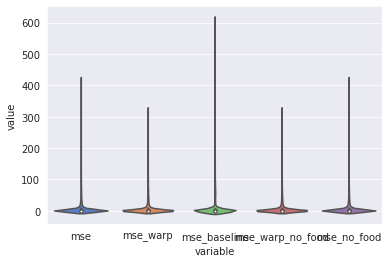

In [14]:
ax = sns.violinplot(x="variable", y="value", data=df_results_tall, palette="muted")

In [ ]:
# print(mse, mse_warp, mse_baseline, mse_warp_no_food, mse_no_food)

In [ ]:
df_train.shape

In [ ]:
res.predict(df_test)

In [ ]:
res.summary()